# Computing Hake NASC from Ship Echosounder Data

Jupyter notebook accompanying the manuscript:

_Echopype: A Python library for interoperable and scalable processing of ocean sonar data for biological information_   
_Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva_

## Introduction

### Description

This notebook uses a small subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey (aka the "Hake survey")](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a processing pipeline that compute Nautical Areal Scattering Coefficient (NASC) attributed to Pacific hake. The workflow includes steps to perform data conversion, calibration, regridding, and masking, using functions from [`Echopype`](https://echopype.readthedocs.io), [`Echoregions`](https://echoregions.readthedocs.io), and core scientific Python software packages, particularly `NumPy`, `Xarray`, and `Dask`. This workflow utilizes Echoregions' compatibility with Echopype data products to incorporate annotations of Pacific hake and seafloor echoes with backscatter measurements. The annotations were manually produced from the NOAA Fisheries Northwest Fisheries Science Center (NWFSC) [Fisheries Engineering and Acoustic Technologies Team (FEAT)](https://www.fisheries.noaa.gov/west-coast/sustainable-fisheries/fisheries-engineering-and-acoustic-technologies-team).

### Outline

1) Convert EK60 `.raw` files to `EchoData` Objects
2) Combine `EchoData` Objects
3) Calibrate raw backscatter measurement in the combined `EchoData` object to Sv
4) Regrid calibrated Sv data to MVBS
5) Generate and apply masks of hake and seafloor echoes within a transect segment
9) Compute and plot NASC attributed to hake

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/conda/environment-ep-main.yml. The notebook creates a directory, if not already present: `./exports/notebook_hake_outputs`. All Zarr files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency.

In [1]:
from pathlib import Path
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # needed for the EK500 colormap
import echoregions as er

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

Set paths and create directories to store Zarr files:

In [2]:
import_path = Path("example_data/NWFSC_2017_hake_survey_transect_with_hake/")

output_path = Path("./exports/notebook_hake_outputs")
output_path.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = output_path / "echodata_zarr"
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = output_path / "combined_zarr"
combined_zarr_path.mkdir(exist_ok=True)

Identify EK60 `.raw` files associated with the first segment of transect 45 of the 2017 survey:

In [3]:
ncei_2017_ek60_raws_path = "ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60"
transect_name = "x0045_0_wt_20170717_213507_f0010"
transect_file_paths = []
with open(import_path / transect_name, 'r') as file:
    for line in file:
        transect_file_paths.append(
            f"{ncei_2017_ek60_raws_path}/{line.strip()}.raw"
        )

In [4]:
transect_file_paths

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T212115.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T214833.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T221909.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T224632.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T231028.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T233247.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T235306.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T001206.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T003054.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T004846.raw']

These RAW files combined are about ~250 MB in size.

### Dask Client Setup

Echopype leverages Dask's lazy-load mechanisms to perform out-of-core and parallelized computation on large datasets. We use the Dask `Client` that is pointed to a `Scheduler` that schedules tasks and allocate memory for these computations.

In [5]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


Click on the Dask Client Dashboard link above to view the computations live.

For more information on how to use, view, and interpret the Dashboard, go to this link: https://docs.dask.org/en/stable/dashboard.html

## Data processing workflow - Echopype

The following data processing steps follow the typical Echopype workflow, which converts and standardizes data before performing more computation. Below we first convert and save the `.raw` files generated by EK60 to Zarr stores on disk, and lazy-load them back for downstream processing. This allows us to perform computations that may require resources that are larger than the local system memory.

### Convert EK60 `.raw` Files to `EchoData` Objects

In [6]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in transect_file_paths:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 2.81 s, sys: 571 ms, total: 3.38 s
Wall time: 26.4 s


###  Combine Echodata Objects

Under the hood of the `ep.combine_echodata` function, the Zarr stores of each `EchoData` object are loaded and appended lazily, meaning that no data loading or appending actually happens until the combined object is saved to disk via `to_zarr`. Since the `EchoData` is appended sequentially based on the data time sequence and therefore not parallelized, this is the slowest stage of the processing pipeline.

In [7]:
%%time

# Open (lazy-load) Zarr stores containing EchoData Objects, and lazily combine them
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save the combined EchoData object to a new Zarr store
# The appending operation only happens when relevant data needs to be save to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazy-load the comined Zarr store
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

CPU times: user 7.43 s, sys: 1.06 s, total: 8.49 s
Wall time: 14.8 s


### Calibrate Combined `EchoData` Object

Compute Volume Backscattering Strength (Sv) from raw backscatter measurements stored in the converted `EchoData` object, and add depth and latitude/longitude to this Xarray Dataset.

In [11]:
%%time

# Chunk EchoData object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000, "range_sample": -1})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 1.44 s, sys: 329 ms, total: 1.77 s
Wall time: 5.66 s


### Regrid Calibrated Data

Compute Mean Volume Backscattering Strength (MVBS), which are binned averages of Sv (in the linear domain) across ping time and depth. This gets the data onto a common grid from the original ping times and depth sample size that may vary across ping and channel depending on the echosounder setting.

In [12]:
%%time

# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='1m',  # in meters
    ping_time_bin='5s',  # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 3.15 s, sys: 843 ms, total: 4 s
Wall time: 18.2 s


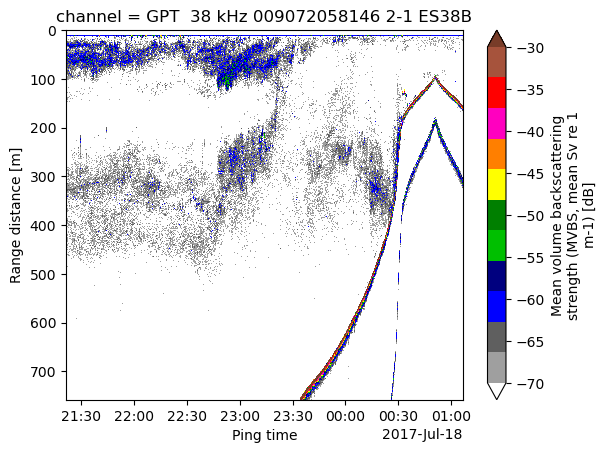

In [13]:
# Plot MVBS from the 38kHz channel
ds_MVBS["Sv"].sel(
    channel="GPT  38 kHz 009072058146 2-1 ES38B"
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

### Generate and apply masks of hake and seafloor echoes within a transect segment

ADD SOME TEXT TO EXPLAIN WHY WE ARE PRODUCING AND COMBINING 3 MASKS BELOW

#### Create a mask for the transect segment

In [14]:
# Parse region annotation (.EVR files) generated in Echoview
regions2d = er.read_evr(import_path / "x0045_regions.evr")

In [15]:
# Extract DataFrame containing region information
r2d_df = regions2d.data

Show start and end time of the transect segment:

In [30]:
transect_start_time = r2d_df[r2d_df['region_name'].str.startswith('ST')]["time"].to_numpy()[0].min()
transect_end_time = r2d_df[r2d_df['region_name'].str.startswith('ET')]["time"].to_numpy()[0].min()
print(
    f"Transect Start Time: {transect_start_time}\n"
    f"Transect End Time: {transect_end_time}"
)

Transect Start Time: 2017-07-17T21:35:07.458000000
Transect End Time: 2017-07-18T00:49:58.195500000


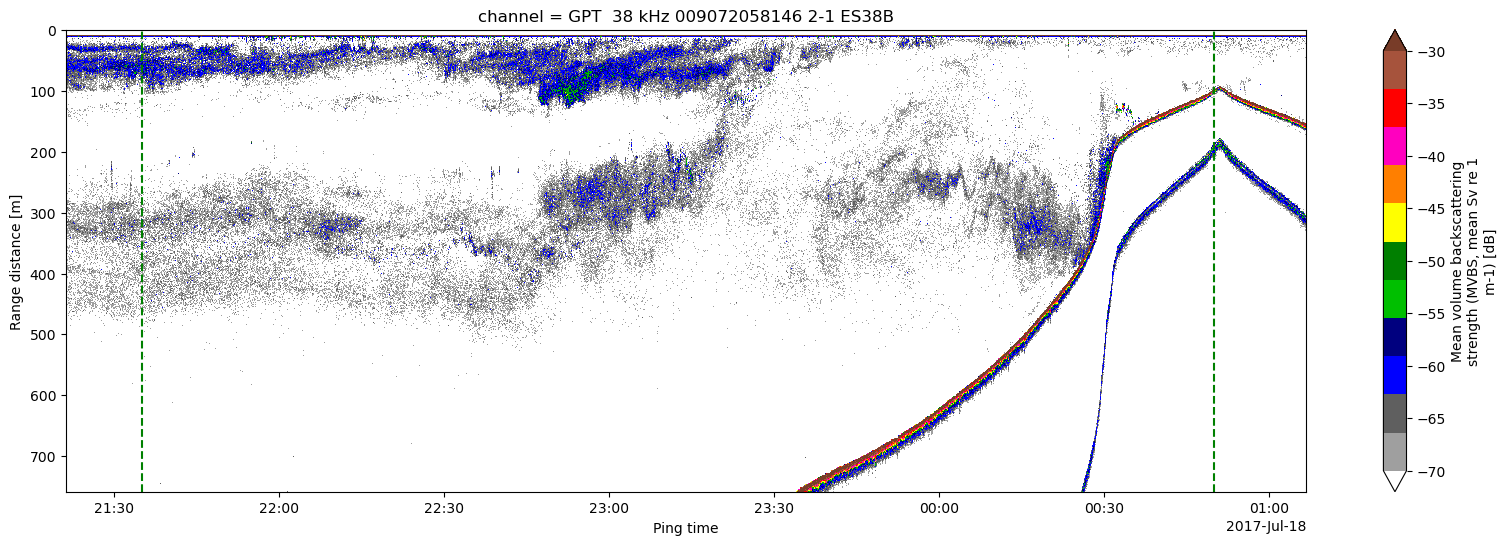

In [31]:
# Create figure
plt.figure(figsize=(20, 6))

# Plot transect start and end times as green vertical dashed lines
plt.axvline(x=transect_start_time, color='green', linestyle='dashed',)
plt.axvline(x=transect_end_time, color='green', linestyle='dashed',)

# Plot the 38 kHz echogram
ds_MVBS["Sv"].isel(channel=1).T.plot(
    y="depth",
    yincrease=False,
    vmin=-70, vmax=-30,
    cmap="ep.ek500"
)

The `transect_mask` method used below implements rules that are specific to the annotation convention for the Hake survey establisehd by the NWFSC FEAT team. Users can use this function by preparing annotations with the same start, break, resume, and end transect designation as described [in the docstring](https://github.com/OSOceanAcoustics/echoregions/blob/main/echoregions/regions2d/regions2d.py#L716). 

If you have a different schema for transect logging, we encourage you to contribute to `Echoregions` by [creating an issue](https://github.com/OSOceanAcoustics/echoregions/issues) to propose adding support for your schema.

In [33]:
# Create a maks for the transect
transect_mask_da = regions2d.transect_mask(ds_MVBS["Sv"])

The transect mask will have all "within transect" segment encoded as 1 and "outside transect" segment encoded as 0, as shown below:

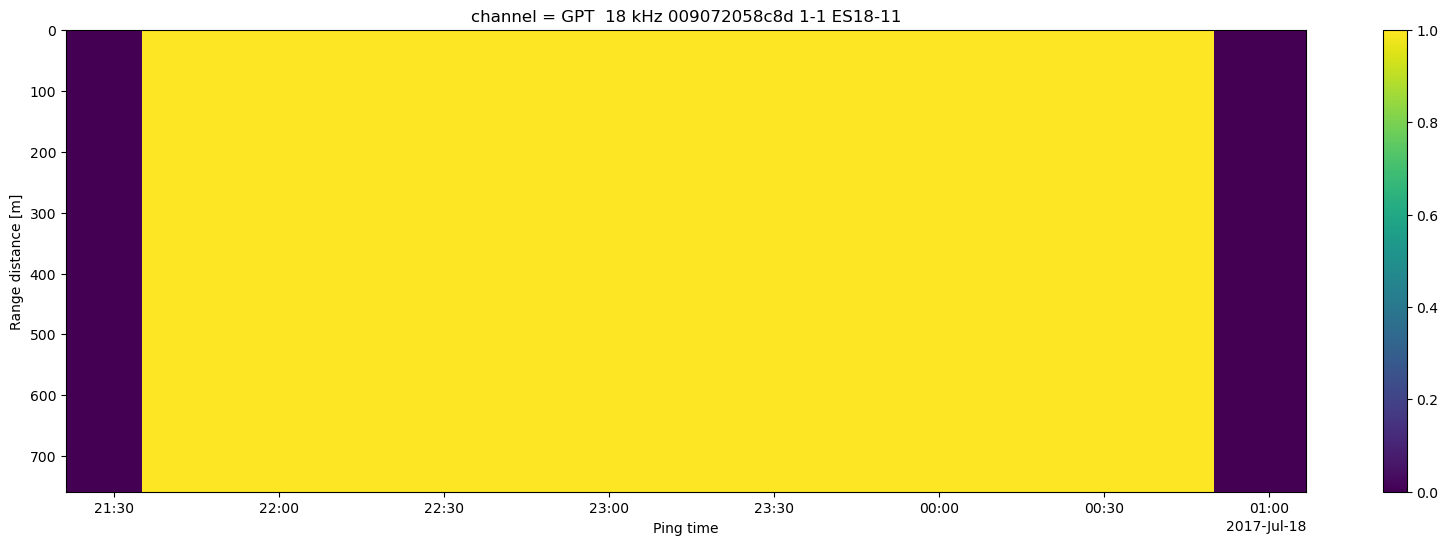

In [35]:
# Plot the transect mask
transect_mask_da.plot(y="depth", yincrease=False, figsize=(20, 6))

Encode "within transect" as `True` and "outside transect" as `False` for use downstream as a boolean mask:

In [36]:
# Turn the transect mask with integer values to a boolean mask
transect_boolean_mask_da = transect_mask_da.astype(bool).transpose(
    "ping_time", "depth"
)

#### Create a mask from annotation of Pacific hake

Below we use `Echoregions` functions to select and produce a mask for regions annotated as Pacific hake on the echogram.

See the [documentation page](https://echoregions.readthedocs.io/en/latest/Regions2D_functionality.html) for more information on using the `Echoregions.Regions2D` object and functionalities.

In [41]:
# Select the hake regions
hake_regions = regions2d.select_region(region_class="Hake")

In [42]:
# Show the hake regions
hake_regions

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
16,x0045_regions.evr,EVRG,7,13.0.378.44817,31,13,10,0,2,-1,...,2017-07-18 00:32:38.498500,165.528208,368.620818,Hake,1,H23U-Region31,"[2017-07-18T00:32:38.498500000, 2017-07-18T00:...","[186.0156202136, 174.8811569187, 165.528207751...",[AWT 23 on line 48],[]
17,x0045_regions.evr,EVRG,7,13.0.378.44817,32,13,76,0,2,-1,...,2017-07-17 22:56:03.693500,315.639445,437.42681,Hake,1,H22U-Region32,"[2017-07-17T22:21:22.711000000, 2017-07-17T22:...","[353.1124807396, 353.1124807396, 337.889060092...","[LCH: Agreed., , JG: This looks like the sig...",[]


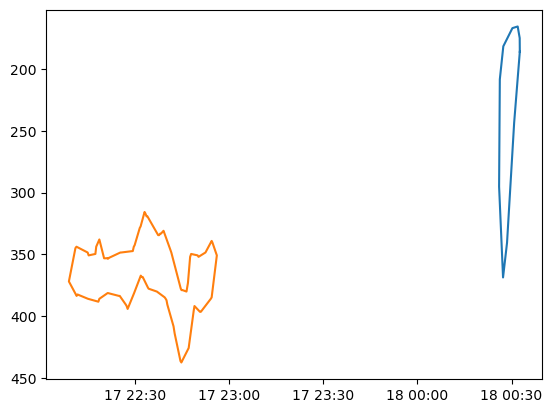

In [43]:
# Plot the hake regions
hake_regions_closed = regions2d.close_region(region_class="Hake")
for _, row in hake_regions_closed.iterrows():
    plt.plot(row["time"], row["depth"])
plt.gca().invert_yaxis()  # since the depth axis is pointed downward
plt.show()

Plotting the hake regions on top of the 38 kHz frequency echogram:

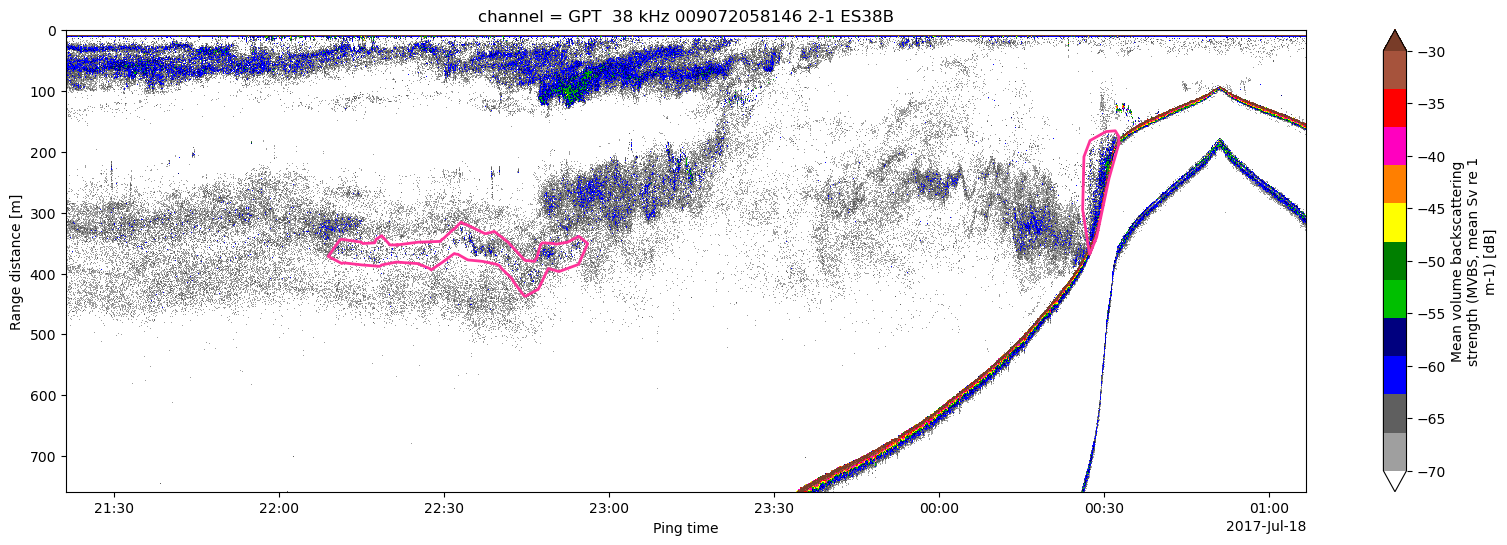

In [44]:
# Plot the echogram with hake regions
plt.figure(figsize=(20, 6))
for _, point in hake_regions_closed.iterrows():
    plt.plot(
        point["time"],
        point["depth"],
        color="#FF3399", # bright pink
        fillstyle='full',
        linewidth=2,
        markersize=1,
    )
ds_MVBS["Sv"].isel(channel=1).T.plot(
    y="depth",
    yincrease=False,
    vmin=-70, vmax=-30,
    cmap="ep.ek500"
)

In [46]:
# Use the built-in function to create a mask for the hake regions
ds_hake_mask, hake_region_points = regions2d.region_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    region_class="Hake",
    collapse_to_2d=True,
)

The generated 2D hake mask will encode background as `NaN`, and the hake regions with their respective `region_id` values (from the `hake_regions` DataFrame shown above).

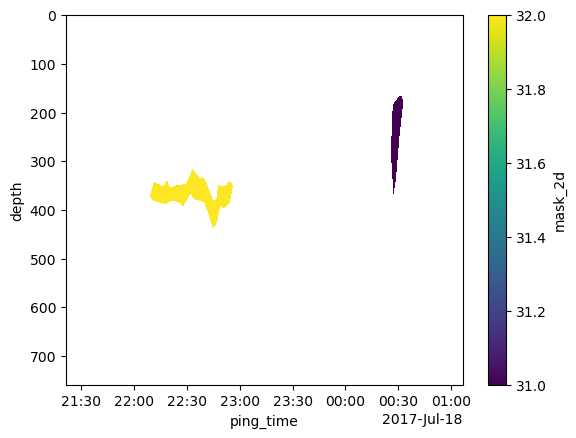

In [47]:
# Plot the hake region mask
ds_hake_mask["mask_2d"].plot(y="depth", yincrease=False)

Encode hake regions as `True` and non-hake regions as `False` for use downstream as a boolean mask:

In [48]:
# Turn mask with integer values to boolean mask
hake_boolean_mask_da = xr.where(
    ds_hake_mask["mask_2d"] > 0, True, False
).transpose("ping_time", "depth")

#### Create a mask from annotation of the seafloor

Below we use `Echoregions` functions to produce a mask for from a line annotated as the seafloor bounary on the echogram.

See the [documentation page](https://echoregions.readthedocs.io/en/latest/Lines_functionality.html) for more information on using the `Echoregions.Lines` object and functionalities.

In [49]:
# Parse seafloor annotation (.EVL) generated in Echoview
lines = er.read_evl(import_path / "x0045_lines.evl")

# Grab lines dataframe
lines_df = lines.data

In [50]:
# Show lines data
lines_df.head(3)

,file_name,file_type,evl_file_format_version,echoview_version,time,depth,status
0,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:37.034000,17.518239,3
1,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:38.044000,16.886161,3
2,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:39.055000,16.537958,3


Note the rightmost column `status`. The `status` values are described by the following:

- 0 = none
- 1 = unverified
- 2 = bad
- 3 = good

The good and bad values are assigned via the specific EVL line picking formula used to generate the EVL file. Generally, we only want the rows with status good/3.

See the Echoview [documentation page](https://support.echoview.com/WebHelp/Using_Echoview/Echogram/Lines/About_Line_Status.htm) for more information on the `status` variable.

In [51]:
# Get only 'good' bottom points
good_lines_df = lines_df[lines_df['status'] == '3']
good_bottom = good_lines_df[['time', 'depth']]
lines.data = good_lines_df

Plotting the Bottom on top of the 38 kHz frequency Echogram:

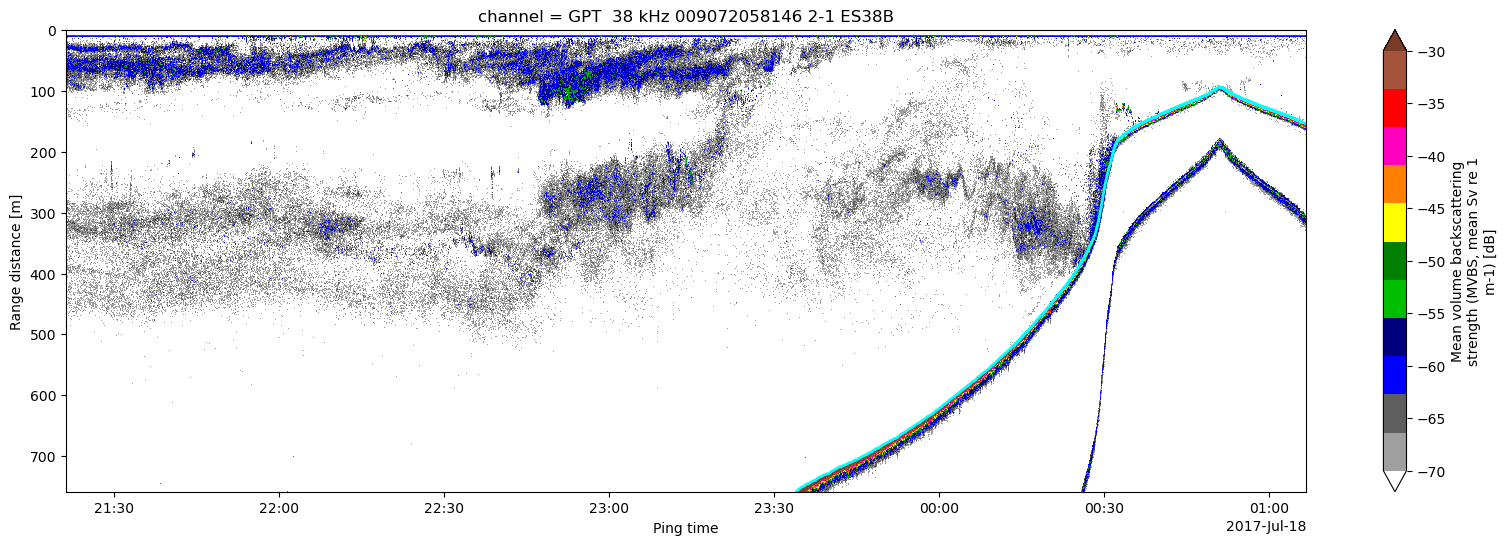

In [52]:
# Plot the seafloor annotation line on the echogram
plt.figure(figsize = (20, 6))
plt.plot(
    lines.data['time'],
    lines.data['depth'],
    color='cyan',
    fillstyle='full',
    linewidth=2,
    markersize=1,
)
ds_MVBS["Sv"].isel(channel=1).T.plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

We can then create a mask for the seafloor boundary:

In [53]:
# Use the built-in mask function
bottom_mask_da, bottom_points = lines.bottom_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    operation="above_below",
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

/Users/wujung/miniconda3/envs/echopype_examples_20240726_2/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


The bottom mask encodes the bottom as 1 and non-bottom as 0:

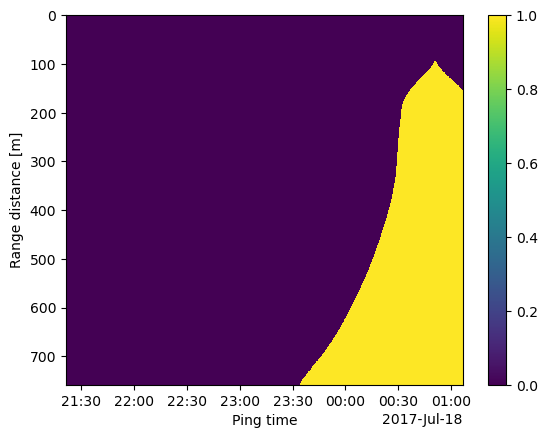

In [54]:
# Plot the bottom mask
bottom_mask_da.plot(y="depth", yincrease=False)

Encode the bottom as `True` and non-bottom as `False` for use downstream as a boolean mask:

In [55]:
# Turn mask with integer values to boolean mask
bottom_boolean_mask_da = bottom_mask_da.astype(bool).transpose("ping_time", "depth")

#### Combine and apply the masks on the MVBS dataset

Prior to masking the MVBS dataset, lets plot all three mask outlines that we want to apply:

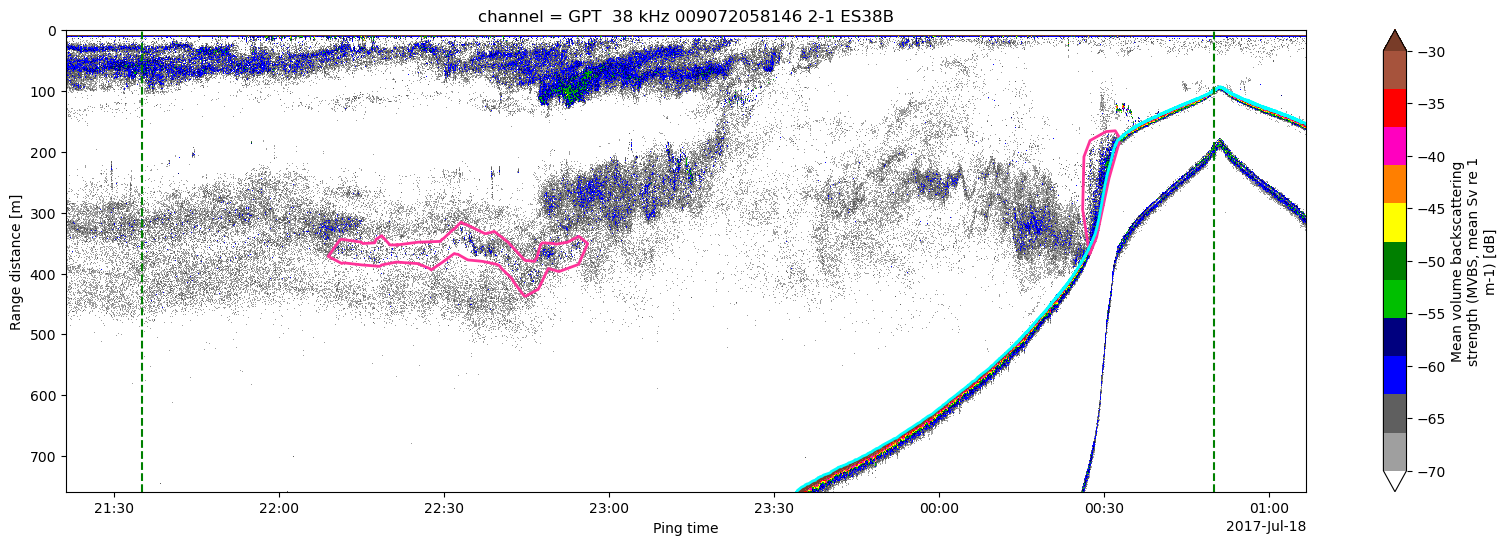

In [56]:
# Create figure
plt.figure(figsize=(20, 6))

# Plot the hake regions
for _, point in hake_regions_closed.iterrows():
    plt.plot(
        point["time"],
        point["depth"],
        color="#FF3399", # bright pink
        fillstyle='full',
        linewidth=2,
        markersize=1,
    )

# Plot the seabed
plt.plot(
    lines.data['time'],
    lines.data['depth'],
    color='cyan',
    fillstyle='full',
    linewidth=2,
    markersize=1,
)

# Plot transect start and end times as green vertical dashed lines
plt.axvline(x=transect_start_time, color='green', linestyle='dashed',)
plt.axvline(x=transect_end_time, color='green', linestyle='dashed',)

# Plot the 38 kHz Echogram
ds_MVBS["Sv"].isel(channel=1).T.plot(
    y="depth",
    yincrease=False,
    vmin=-70, vmax=-30,
    cmap="ep.ek500"
)

In the above we can see that there is an overlap between the seafloor annotation and the rightmost hake region annotation. This overlap will be removed from the hake region when we apply the mask, so that the final masked MVBS dataset would not contain "contamination" from seafloor echoes:

In [57]:
# Apply the three masks on MVBS
ds_MVBS_transect_cleaned_hake = ep.mask.apply_mask(
    ds_MVBS,
    [
        hake_boolean_mask_da,
        ~bottom_boolean_mask_da, # Negate since we don't want bottom
        transect_boolean_mask_da,
    ]
)

**Note**: The reason we converted all our masks into boolean masks is because, under the hood, `apply_mask` performs a logical AND element-wise operation across the list of masks to create a single mask, which is then applied to mask the MVBS dataset.

Let's check the 38 kHz channel of the masked MVBS dataset:

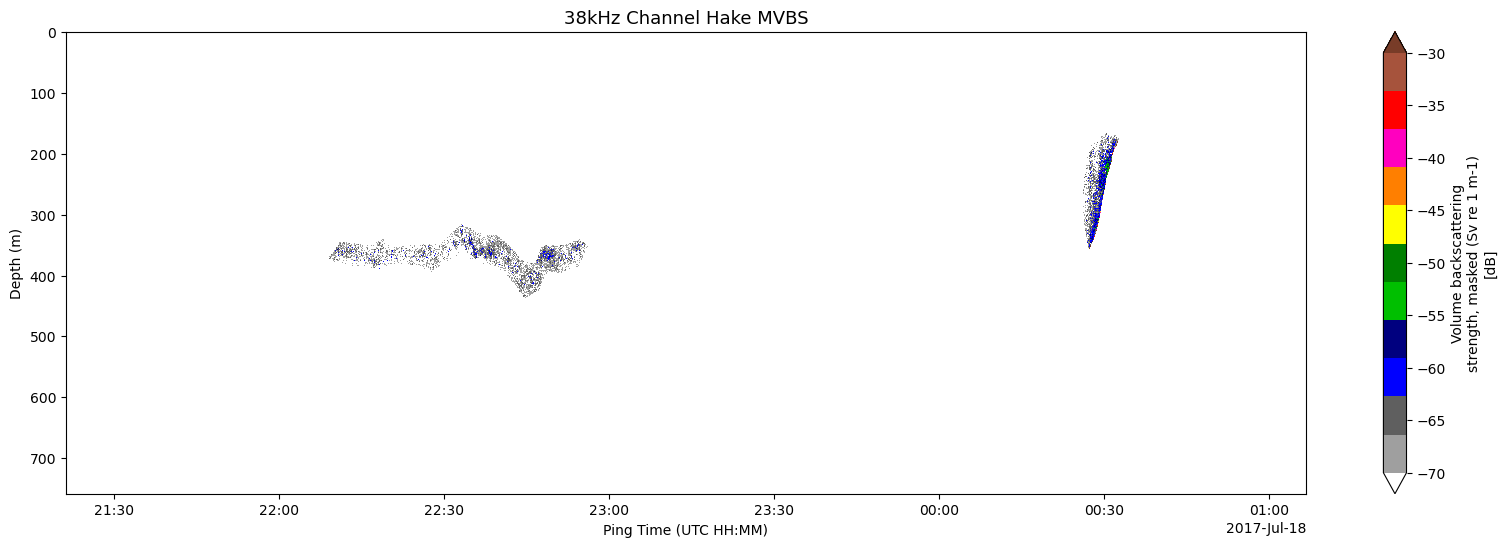

In [58]:
# Add attributes to depth and ping time
ds_MVBS_transect_cleaned_hake["depth"].attrs["long_name"] = "Depth (m)"
ds_MVBS_transect_cleaned_hake["ping_time"].attrs["long_name"] = "Ping Time (UTC HH:MM)"

# Plot 38 kHz MVBS attributed to Clean Hake
p = ds_MVBS_transect_cleaned_hake["Sv"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
    figsize=(20, 6)
)

# Set axes title
p.axes.set_title("38kHz Channel Hake MVBS", fontsize=13)

# Show plot
plt.show()

Zoomed in to make sure the masked MVBS is free from contamination of seafloor echoes:

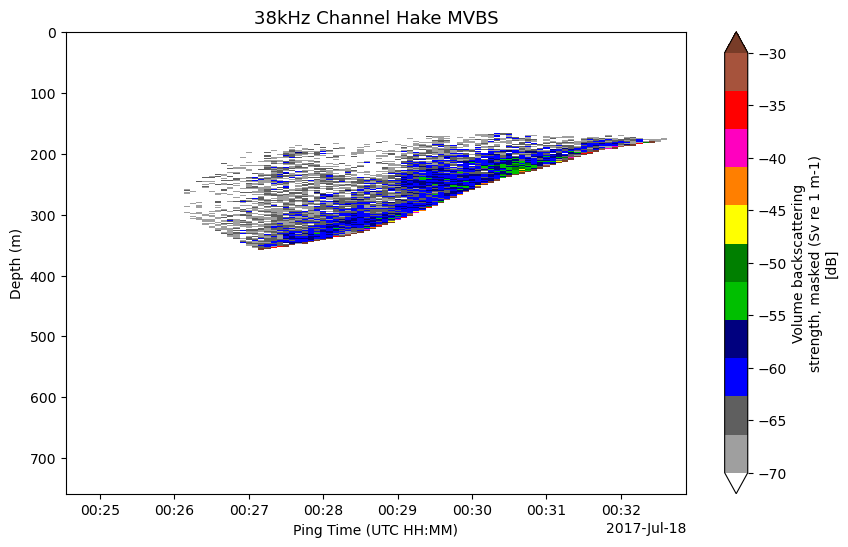

In [74]:
# Add attributes to depth and ping time
ds_MVBS_transect_cleaned_hake["depth"].attrs["long_name"] = "Depth (m)"
ds_MVBS_transect_cleaned_hake["ping_time"].attrs["long_name"] = "Ping Time (UTC HH:MM)"

# Plot 38 kHz MVBS attributed to Clean Hake
p = ds_MVBS_transect_cleaned_hake["Sv"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).isel(ping_time=slice(2200, 2300)).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
    figsize=(10, 6)
)

# Set axes title
p.axes.set_title("38kHz Channel Hake MVBS", fontsize=13)

# Show plot
plt.show()

### Compute and Plot NASC Attributed to Pacific Hake

In [85]:
# Compute NASC from the masked MVBS dataset
ds_NASC = ep.commongrid.compute_NASC(
    ds_MVBS_transect_cleaned_hake,
    range_bin="10m",
    dist_bin="0.5nmi"
)

# Log-transform the NASC values for plotting
ds_NASC["NASC_log"] = 10 * np.log10(ds_NASC["NASC"])
ds_NASC["NASC_log"].attrs = {
    "long_name": "Log of NASC",
    "units": "m2 nmi-2"
}

In [86]:
# Show the hake NASC dataset
ds_NASC

<xarray.Dataset> Size: 295kB
Dimensions:            (channel: 3, distance: 80, depth: 76)
Coordinates:
  * distance           (distance) float64 640B 0.0 0.5 1.0 ... 38.5 39.0 39.5
  * channel            (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES18...
  * depth              (depth) float64 608B 0.0 10.0 20.0 ... 730.0 740.0 750.0
Data variables:
    NASC               (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
    latitude           (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    longitude          (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    ping_time          (distance) datetime64[ns] 640B 2017-07-17T21:23:27.500...
    frequency_nominal  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    NASC_log           (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.7,ACDD-1.3
    time_coverage_start:   2017-07-17T21:21:15.000000000Z
    time_coverage_end:     2017-07-18T01:06:35.000000000Z
    geospatial_lat_min:    41.79633
    geospatial_lat_max:    41.82402
    geospatial_lon_min:    -125.21041
    geospatial_lon_max:    -124.41516
    processing_level:      Level 4
    processing_level_url:  https://echopype.readthedocs.io/en/stable/processi...

We plot the NASC values in log scale due to the wide range of values:

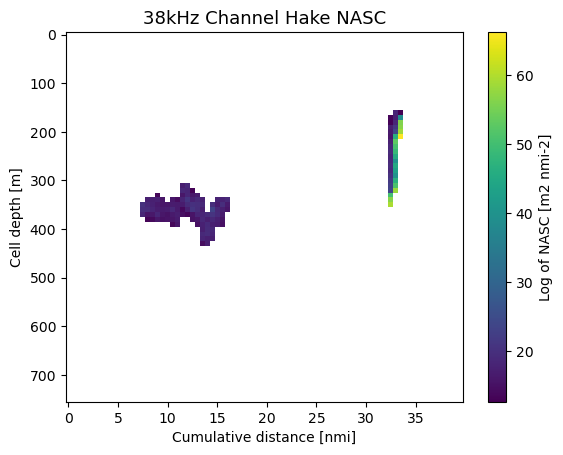

In [87]:
# Plot 38 kHz hake NASC
p = ds_NASC["NASC_log"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    cmap="viridis"
)

# Set axes title
p.axes.set_title("38kHz Channel Hake NASC", fontsize=13)

# Show plot
plt.show()

## Package versions

In [88]:
import datetime
import dask
print(f"echopype: {ep.__version__}, echoregions: {er.__version__}, xarray: {xr.__version__}, dask: {dask.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.5.dev82+gf9c1b27, echoregions: 0.2.2.dev2, xarray: 2024.6.0, dask: 2024.7.1

2024-07-27 19:36:19.045023 +00:00
